# **Import Library And Load Datasets**

In [1]:
# !rm -rf /content/Dataset

# !rm -rf /content/checkpoint

# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
import os
from glob import glob
import shutil
from sklearn.model_selection import train_test_split


bicycle = glob("/content/drive/MyDrive/ImageClassification/datasets/bicycle/*.jpg")

print(f"Bicycle:{len(bicycle)}")

motorcycle = glob("/content/drive/MyDrive/ImageClassification/datasets/motorcycle/*.jpg")

print(f"Motorcycle:{len(motorcycle)}")

Bicycle:134
Motorcycle:139


# **Train Test Splite Datases**

In [3]:
train_bicycle, val_bicycle = train_test_split(bicycle, shuffle=True, test_size=0.1, random_state=44)

train_motorcycle, val_motorcycle = train_test_split(motorcycle, shuffle=True, test_size=0.1, random_state=44)


print(f"Bicycle[Train]={len(train_bicycle)}, Bicycle[Val]={len(val_bicycle)}")
print(f"Motorcycle[Train]={len(train_motorcycle)}, Motorcycle[Val]={len(val_motorcycle)}")

Bicycle[Train]=120, Bicycle[Val]=14
Motorcycle[Train]=125, Motorcycle[Val]=14


# ***Splite Image For Train & Validation***

In [4]:
# Train
os.makedirs("/content/Dataset/train/", exist_ok=True)
os.makedirs("/content/Dataset/train/bicycle", exist_ok=True)
os.makedirs("/content/Dataset/train/motorcycle", exist_ok=True)

#Validation
os.makedirs("/content/Dataset/val/", exist_ok=True)
os.makedirs("/content/Dataset/val/bicycle", exist_ok=True)
os.makedirs("/content/Dataset/val/motorcycle", exist_ok=True)

In [5]:
for image_path in train_bicycle:
  shutil.copy(image_path,"/content/Dataset/train/bicycle")

for image_path in train_motorcycle:
  shutil.copy(image_path,"/content/Dataset/train/motorcycle")


for image_path in val_bicycle:
  shutil.copy(image_path,"/content/Dataset/val/bicycle")

for image_path in val_motorcycle:
  shutil.copy(image_path,"/content/Dataset/val/motorcycle")

print(f"Train[Bicycle] = {len(glob('/content/Dataset/train/bicycle/*.jpg'))}")
print(f"Train[Motorcycle] = {len(glob('/content/Dataset/train/motorcycle/*.jpg'))}")

print(f"Validation[Bicycle] = {len(glob('/content/Dataset/val/bicycle/*.jpg'))}")
print(f"Validation[Motorcycle] = {len(glob('/content/Dataset/val/motorcycle/*.jpg'))}")


Train[Bicycle] = 120
Train[Motorcycle] = 125
Validation[Bicycle] = 14
Validation[Motorcycle] = 14


# Custom Dataset

In [6]:
import os
import torch
import random
from glob import glob
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt



class CycleDataset(Dataset):
  def __init__(self, dataset_path, transform):
    # "/content/Dataset/train"
    dataset_path = os.path.join(dataset_path, "**", "*.jpg")
    self.images = glob(dataset_path, recursive=True)
    self.transform = transform
    random.shuffle(self.images)
    print(f"Images:{len(self.images)}")

    #bicycle => 0 , motorcycle => 1
    self.class_to_idx = {
        "bicycle" : 0,
        "motorcycle" : 1
    }


  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = self.images[index]
    # print(image_path)
    # /content/Dataset/train/bicycle/1 (1).jpg
    class_name = image_path.split("/")[-2]
    label = self.class_to_idx[class_name]
    # print(class_name)
    # print(class_name, self.class_to_idx[class_name])

    # print(f"Class Name: {class_name}, ID Class: {self.class_to_idx[class_name]}")

    image = Image.open(image_path).convert("RGB")

    # plt.subplot(1, 2, 1)
    # plt.imshow(image, cmap='gray')

    #Augmentation
    if self.transform:
      image = self.transform(image)

    # plt.subplot(1,2,2)
    # plt.imshow(image)
    # plt.show()

    z = torch.zeros(2)
    z[label] = 1
    # print(z)
    return image, label, z

#Train Transformer
train_transform = T.Compose([
    T.Resize((224,224)),
    T.ColorJitter(brightness=0.5, hue=0.3),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
train_dataset = CycleDataset(dataset_path = "/content/Dataset/train", transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=30)


#Val Transformer
val_transform = T.Compose([
    T.Resize((224,224)),
    #T.ColorJitter(brightness=0.5, hue=0.3),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
val_dataset = CycleDataset(dataset_path = "/content/Dataset/val", transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=30)

# for batch in val_loader:
#   print(batch[0].shape, batch[1], batch[2] )


Images:245
Images:28


# Create Class AvrageMeter

In [7]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0       # مقدار جاری
        self.avg = 0       # میانگین
        self.sum = 0       # مجموع
        self.count = 0     # تعداد نمونه‌ها

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

avg_meter = AverageMeter()

avg_meter.update(val=1.1, n=2)
avg_meter.update(val=0.9, n=2)

print(avg_meter.avg)

1.0


# Train Model

In [8]:
!pip install transformers

In [9]:
!pip install torchmetrics

In [10]:
from transformers import SwinForImageClassification
from torch import optim
from torch import nn
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
import torch
import os

class Training:

  def __init__(self, epochs:int) -> None:
     self.epochs = epochs

     self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     self.model = self.load_model().to(self.device)
     self.optimizer = optim.Adam(params=self.model.parameters(), lr = 0.0001 )

     self.scheduler  =optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max= 5000, eta_min=1e-6)

     self.loss_fn = nn.CrossEntropyLoss()

     self.metric = BinaryAccuracy().to(self.device)


  def load_model(self, weight_path=None):
      model = SwinForImageClassification.from_pretrained(
          "microsoft/swin-tiny-patch4-window7-224",
          num_labels=2,
          ignore_mismatched_sizes=True
      )

      if weight_path is not None:
          model.load_state_dict(torch.load(weight_path, map_location=self.device))
          # print(f"Loaded weights from {weight_path}")

      return model


  def train(self, train_loader):
    self.model.train()
    loss_train =  AverageMeter()
    self.metric.reset()

    for index ,(inputs, labels, z) in enumerate(train_loader):
      inputs = inputs.to(self.device)
      labels = labels.to(self.device)
      z = z.to(self.device)

      self.optimizer.zero_grad()

      outputs = self.model(inputs)

      loss = self.loss_fn(outputs.logits, labels)

      loss.backward()

      self.optimizer.step()
      loss_train.update(loss.item(), n =len(labels))
      self.metric.update(outputs.logits, z)

      if index % 25 == 0:
        print(f"{index} / {len(train_loader)}")


    self.scheduler.step()


    return loss_train.avg, self.metric.compute().item()




  def validation(self,val_loader):
    self.model.eval()
    loss_val = AverageMeter()
    self.metric.reset()

    for index, (inputs, labels,z) in enumerate(val_loader):
      inputs = inputs.to(self.device)
      labels = labels.to(self.device)
      z = z.to(self.device)

      with torch.inference_mode():
        outputs =self.model(inputs)

      loss = self.loss_fn(outputs.logits,z)

      # loss.val.update(loss.item(), n=len(labels))
      loss_val.update(loss.item(), n=len(labels))
      self.metric.update(outputs.logits, z)

    return loss_val.avg, self.metric.compute().item()



  def save_model(self, epoch, path="checkpoint/swin_finetuned.pt"):
      import os
      os.makedirs(os.path.dirname(path), exist_ok=True)
      torch.save(self.model.state_dict(), path)
      print(f"[Epoch {epoch}] Model saved to {path}")


  def run(self):

    best_val_loss = torch.inf

    for epoch in range(1, self.epochs + 1):

      print(epoch)

      # train
      loss_train, acc_train = self.train(train_loader)
      print(f"Loss Train:{loss_train}, Acc Train:{acc_train}")
      # validation
      loss_val, acc_val = self.validation(val_loader)
      print(f"Loss Validation:{loss_val}, Acc Validation:{acc_val}")


      if loss_val < best_val_loss :
        best_val_loss = loss_val
        self.save_model(epoch= epoch)
    print(best_val_loss)



In [11]:
tranings_class =Training(epochs=10)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-str

In [12]:
tranings_class.run()

1
0 / 9
Loss Train:0.42017098470610015, Acc Train:0.7857142686843872
Loss Validation:0.03141837194561958, Acc Validation:1.0
[Epoch 1] Model saved to checkpoint/swin_finetuned.pt
2
0 / 9
Loss Train:0.054423995354041764, Acc Train:0.981632649898529
Loss Validation:0.2517520487308502, Acc Validation:0.9285714030265808
3
0 / 9
Loss Train:0.06021442201596742, Acc Train:0.9714285731315613
Loss Validation:0.18379317224025726, Acc Validation:0.9464285969734192
4
0 / 9
Loss Train:0.03698291466808973, Acc Train:0.9795918464660645
Loss Validation:0.008938799612224102, Acc Validation:1.0
[Epoch 4] Model saved to checkpoint/swin_finetuned.pt
5
0 / 9
Loss Train:0.007897013375459581, Acc Train:0.9979591965675354
Loss Validation:0.007100373972207308, Acc Validation:1.0
[Epoch 5] Model saved to checkpoint/swin_finetuned.pt
6
0 / 9
Loss Train:0.0013973558445137982, Acc Train:1.0
Loss Validation:0.0025707033928483725, Acc Validation:1.0
[Epoch 6] Model saved to checkpoint/swin_finetuned.pt
7
0 / 9
Loss 

In [13]:
inf = Training(epochs=10)

model = inf.load_model(weight_path="/content/checkpoint/swin_finetuned.pt")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN

In [14]:
    #bicycle => 0 , motorcycle => 1
    class_to_idx = {
        "bicycle" : 0,
        "motorcycle" : 1
    }


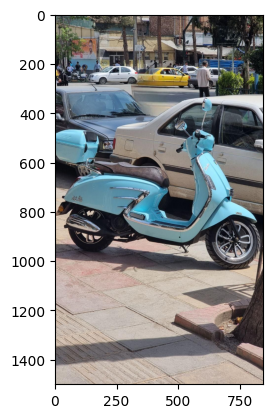

torch.Size([1, 3, 224, 224])

In [27]:
from PIL import Image
from matplotlib import pyplot as plt
IMAGE_PATH = "/content/4444444.jpg"

image = Image.open(IMAGE_PATH).convert("RGB")
test_transform = T.Compose([
    T.Resize((224,224)),
    #T.ColorJitter(brightness=0.5, hue=0.3),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
plt.imshow(image)
plt.show()
image = test_transform(image)

image = torch.unsqueeze(image, dim=0)

image.shape

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [29]:
model = model.to(device)
image = image.to(device)

In [30]:
model.eval()

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [31]:
with torch.inference_mode():
  output = model(image)

In [32]:
output

SwinImageClassifierOutput(loss=None, logits=tensor([[-2.7632,  3.3458]]), hidden_states=None, attentions=None, reshaped_hidden_states=None)

In [33]:
class_to_idx

{'bicycle': 0, 'motorcycle': 1}

In [34]:
output.logits

tensor([[-2.7632,  3.3458]])

In [35]:
_, pred =torch.max(output.logits, 1)

In [36]:
print("predic:", pred.item())

predic: 1


In [37]:
idx_to_class ={
    0:"bicycle",
    1:"motorcycle"
}

In [38]:
print(f"Predicted:{idx_to_class[pred.item()]}")

Predicted:motorcycle
